In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

import tensorflow as tf
from tensorflow import keras
# from tensorflow.keras.layers import Conv2D, MaxPooling2D,  Dropout, Dense, Activation, BatchNormalization, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
import itertools

/Users/daihongchen/opt/anaconda3/envs/flask-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/daihongchen/opt/anaconda3/envs/flask-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/daihongchen/opt/anaconda3/envs/flask-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/

In [2]:
# import data
data_file = '../data/2018_movie_links.csv'

In [3]:
tf.__version__

'1.14.0'

In [4]:
data_2018 = pd.read_csv(data_file)

In [5]:
data_2018 = data_2018.drop(['Unnamed: 0', 'verified', 'rank', 'also_buy', 'also_view', 'details'], axis=1)

In [6]:
data_2018.shape

(209060, 17)

In [7]:
data_2018 = data_2018.rename(columns={'overall':'rating', 'asin':'movieID'})

In [8]:
reviewer_count = data_2018.groupby('reviewerID')['rating'].count()
product_count = data_2018.groupby('movieID')['rating'].count()
average_rating = data_2018.groupby('movieID')['rating'].mean()

In [9]:
# remove reviewers that has only one review.
data_2018_1 = data_2018.merge(reviewer_count, on='reviewerID')

In [10]:
data_2018_1 = data_2018_1.rename(columns={'rating_y':'reviewer_count', 'rating_x':'rating'})

In [11]:
data_2018_1 = data_2018_1.merge(product_count, on='movieID')

In [12]:
data_2018_1 = data_2018_1.rename(columns={'rating_y':'movie_count', 'rating_x':'rating'})

In [13]:
data_2018_1 = data_2018_1.merge(average_rating, on='movieID')

In [14]:
data_2018_1 = data_2018_1.rename(columns={'rating_y':'average_rating', 'rating_x':'rating'})

In [15]:
data_2018_1.shape

(209060, 20)

In [16]:
# data_2018_1.to_csv('data_2018_clean.csv')

In [17]:
data_2018_1 = data_2018_1[data_2018_1['reviewer_count']>1]
data_2018_1 = data_2018_1[data_2018_1['movie_count']>1]

In [18]:
# data_2018_1.to_csv('data_2018_final.csv')

In [19]:
data_2018_1.head()

,rating,reviewTime,reviewerID,movieID,style,reviewerName,reviewText,summary,unixReviewTime,vote,category,title,main_cat,description,brand,price,links,reviewer_count,movie_count,average_rating
0,5.0,"04 8, 2018",A1CW3NLH9MBQRY,6303022901,{'Format:': ' DVD'},Sally Nunez,I really enjoyed this movie. Brings tears to m...,Five Stars,1523145600,NaN,"['Movies & TV', 'Genre for Featured Categories...",The Joy Luck Club VHS,Movies & TV,['Produced by Academy Award(R)-winning filmmak...,Tamlyn Tomita,$3.28,https://www.amazon.com/product-reviews/6303022...,3,21,4.857143
1,5.0,"04 2, 2018",A1WK0IRZ08NX9X,6303022901,{'Format:': ' DVD'},Ammie28,"If you have never seen this movie, you may jus...",Heart Touching...,1522627200,NaN,"['Movies & TV', 'Genre for Featured Categories...",The Joy Luck Club VHS,Movies & TV,['Produced by Academy Award(R)-winning filmmak...,Tamlyn Tomita,$3.28,https://www.amazon.com/product-reviews/6303022...,4,21,4.857143
2,5.0,"03 30, 2018",A2HGXJQCQTXE4E,6303022901,{'Format:': ' Blu-ray'},Pa nhia lee,awesome all time fave movie.,Five Stars,1522368000,NaN,"['Movies & TV', 'Genre for Featured Categories...",The Joy Luck Club VHS,Movies & TV,['Produced by Academy Award(R)-winning filmmak...,Tamlyn Tomita,$3.28,https://www.amazon.com/product-reviews/6303022...,4,21,4.857143
3,5.0,"03 30, 2018",A14ASTA78EK120,6303022901,{'Format:': ' DVD'},lalush,The greatest movie ever!!!!!,Five Stars,1522368000,NaN,"['Movies & TV', 'Genre for Featured Categories...",The Joy Luck Club VHS,Movies & TV,['Produced by Academy Award(R)-winning filmmak...,Tamlyn Tomita,$3.28,https://www.amazon.com/product-reviews/6303022...,3,21,4.857143
4,5.0,"03 29, 2018",A2EGT1RXKVOXTJ,6303022901,{'Format:': ' Amazon Video'},Karin,Love this movie,Five Stars,1522281600,NaN,"['Movies & TV', 'Genre for Featured Categories...",The Joy Luck Club VHS,Movies & TV,['Produced by Academy Award(R)-winning filmmak...,Tamlyn Tomita,$3.28,https://www.amazon.com/product-reviews/6303022...,3,21,4.857143


## encode reviewerID and movieID to index

In [20]:
from sklearn.preprocessing import LabelEncoder
reviewer_enc = LabelEncoder()
data_2018_1['reviewer'] = reviewer_enc.fit_transform(data_2018_1['reviewerID'].astype(str).values)
n_reviewers = data_2018_1['reviewer'].nunique()
movie_enc = LabelEncoder()
data_2018_1['movie'] = movie_enc.fit_transform(data_2018_1['movieID'].astype(str).values)
n_movies = data_2018_1['movie'].nunique()
data_2018_1['rating'] = data_2018_1['rating'].values.astype(np.float32)
min_rating = min(data_2018_1['rating'])
max_rating = max(data_2018_1['rating'])
print(n_reviewers, n_movies)

35992 20298


In [21]:
X = data_2018_1[['reviewer','movie']].values
y = data_2018_1['rating'].values
X.shape, y.shape

((116700, 2), (116700,))

In [22]:
# data_2018_1.to_csv('data_2018_mr.csv')

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((93360, 2), (23340, 2), (93360,), (23340,))

# Create the model

In [24]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [25]:
n_factors = 50
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]
X_train_array

[array([ 5018, 35266, 17517, ..., 30249, 13358, 17876]),
 array([ 4529, 19032,  2301, ..., 19037, 19796,  8285])]

In [26]:
def RecommenderV4(n_reviewers, n_movies, n_factors, loss, opt, metrics):
    reviewer = Input(shape=(1,))
    r = Embedding(n_reviewers, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(reviewer)
    r = Reshape((n_factors,))(r)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Reshape((n_factors,))(m)
    
    x = Dot(axes=1)([r, m])
    model = Model(inputs=[reviewer, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss=loss, optimizer=opt, metrics=metrics)
    return model

In [27]:
loss='mean_squared_error'
opt = Adam(lr=0.001)
n_factors=50
metrics=['mae']

model1 = RecommenderV4(n_reviewers, n_movies,n_factors, loss, opt, metrics)
# model1.summary()

In [41]:
## base model
history1 = model1.fit(x=X_train_array, 
                     y=y_train, 
                     batch_size=64, 
                     epochs=5,
                     verbose=1,
                     validation_data=(X_test_array, y_test))

Train on 93360 samples, validate on 23340 samples
Epoch 1/5


/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


93360/93360 [==============================] - 33s 352us/sample - loss: 20.7207 - mae: 4.4142 - val_loss: 20.4751 - val_mae: 4.3900
Epoch 2/5
93360/93360 [==============================] - 30s 321us/sample - loss: 18.4844 - mae: 4.1246 - val_loss: 18.3583 - val_mae: 4.0967
Epoch 3/5
93360/93360 [==============================] - 31s 329us/sample - loss: 13.9285 - mae: 3.4322 - val_loss: 16.0430 - val_mae: 3.7132
Epoch 4/5
93360/93360 [==============================] - 31s 327us/sample - loss: 9.6365 - mae: 2.6739 - val_loss: 14.3062 - val_mae: 3.3736
Epoch 5/5
93360/93360 [==============================] - 30s 325us/sample - loss: 6.3658 - mae: 2.0250 - val_loss: 13.1600 - val_mae: 3.1193


In [42]:
model1.save('base_model.h5')

In [46]:
with open('base_model.pkl', 'wb') as f:
    pkl.dump(model1, f)

TypeError: can't pickle _thread.RLock objects

In [47]:
model1.fit(x=X_train_array, 
                     y=y_train, 
                     batch_size=64, 
                     epochs=1,
                     verbose=1,
                     validation_data=(X_test_array, y_test))

Train on 93360 samples, validate on 23340 samples
93360/93360 [==============================] - 31s 329us/sample - loss: 4.0547 - mae: 1.5011 - val_loss: 12.4273 - val_mae: 2.9377


In [48]:
with open('base_model.pkl', 'wb') as f:
    pkl.dump(model1, f)

TypeError: can't pickle _thread.RLock objects

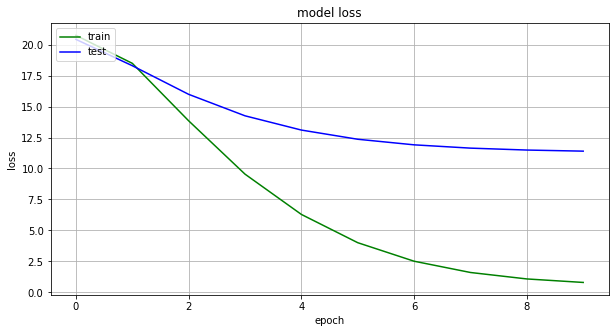

In [568]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'] , 'g')
plt.plot(history1.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [28]:
from tensorflow.keras.layers import Add, Activation, Lambda
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x
def RecommenderV5(n_reviewers, n_movies, n_factors, min_rating, max_rating):
    reviewer = Input(shape=(1,))
    r = EmbeddingLayer(n_reviewers, n_factors)(reviewer)
    rb = EmbeddingLayer(n_reviewers, 1)(reviewer)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    mb = EmbeddingLayer(n_movies, 1)(movie)
    x = Dot(axes=1)([r, m])
    x = Add()([x, rb, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[reviewer, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
    return model

In [31]:
model = RecommenderV5(n_reviewers, n_movies, n_factors, min_rating, max_rating)
# model.summary()

In [409]:
history = model.fit(x=X_train_array, 
                    y=y_train, 
                    batch_size=64, 
                    epochs=15,
                    verbose=1, 
                    validation_data=(X_test_array, y_test))

Train on 93360 samples, validate on 23340 samples
Epoch 1/15


/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


93360/93360 [==============================] - 28s 298us/sample - loss: 3.0162 - mae: 1.6457 - val_loss: 2.7017 - val_mae: 1.5508
Epoch 2/15
93360/93360 [==============================] - 26s 280us/sample - loss: 2.1164 - mae: 1.3358 - val_loss: 2.0679 - val_mae: 1.3085
Epoch 3/15
93360/93360 [==============================] - 27s 286us/sample - loss: 1.2256 - mae: 0.9434 - val_loss: 1.7026 - val_mae: 1.1303
Epoch 4/15
93360/93360 [==============================] - 28s 301us/sample - loss: 0.6859 - mae: 0.6465 - val_loss: 1.5222 - val_mae: 1.0206
Epoch 5/15
93360/93360 [==============================] - 28s 300us/sample - loss: 0.4047 - mae: 0.4497 - val_loss: 1.4296 - val_mae: 0.9517
Epoch 6/15
93360/93360 [==============================] - 28s 303us/sample - loss: 0.2708 - mae: 0.3268 - val_loss: 1.3785 - val_mae: 0.9073
Epoch 7/15
93360/93360 [==============================] - 28s 300us/sample - loss: 0.2102 - mae: 0.2543 - val_loss: 1.3427 - val_mae: 0.8764
Epoch 8/15
93360/93360 [

# Add layers to model as deep learning

In [31]:
from tensorflow.keras.layers import Concatenate, Dense, Dropout
from tensorflow.keras.layers import Add, Activation, Lambda

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

def RecommenderNet(n_reviewers, n_movies, n_factors, min_rating, max_rating):
    reviewer = Input(shape=(1,))
    r = EmbeddingLayer(n_reviewers, n_factors)(reviewer)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([r, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[reviewer, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
    return model

In [32]:
model6 = RecommenderNet(n_reviewers, n_movies, n_factors, min_rating, max_rating)
# model6.summary()

In [33]:
history2 = model6.fit(x=X_train_array, 
                    y=y_train, 
                    batch_size=64, 
                    epochs=5,
                    verbose=1, 
                    validation_data=(X_test_array, y_test))

Train on 93360 samples, validate on 23340 samples
Epoch 1/5
93360/93360 [==============================] - 55s 591us/sample - loss: 1.3970 - mean_absolute_error: 0.8557 - val_loss: 0.8837 - val_mean_absolute_error: 0.5246
Epoch 2/5
93360/93360 [==============================] - 54s 580us/sample - loss: 0.7342 - mean_absolute_error: 0.4839 - val_loss: 0.7635 - val_mean_absolute_error: 0.4554
Epoch 3/5
93360/93360 [==============================] - 55s 590us/sample - loss: 0.5383 - mean_absolute_error: 0.3829 - val_loss: 0.7361 - val_mean_absolute_error: 0.4337
Epoch 4/5
93360/93360 [==============================] - 55s 592us/sample - loss: 0.4512 - mean_absolute_error: 0.3294 - val_loss: 0.7601 - val_mean_absolute_error: 0.4251
Epoch 5/5
93360/93360 [==============================] - 55s 591us/sample - loss: 0.4049 - mean_absolute_error: 0.2965 - val_loss: 0.7785 - val_mean_absolute_error: 0.4185


In [34]:
model6.save('mr_model.h5')

In [35]:
mode_test = load_model('mr_model.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [32]:
# Save weights and architecture
model6.save_weights("weights_only.h5") #replace 'model' with the name of your model
# Save model config
json_config = model6.to_json()
with open('model_config.json', 'w') as json_file: 
    json_file.write(json_config)

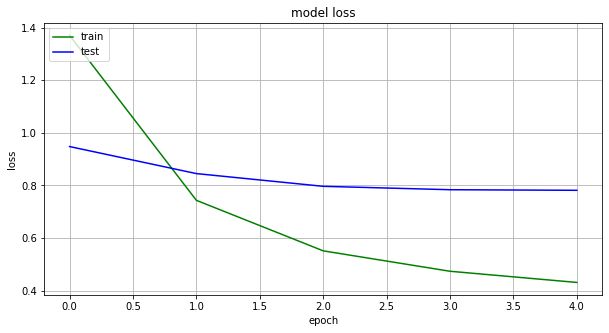

In [570]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'] , 'g')
plt.plot(history2.history['val_loss'] , 'b')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [462]:
model6.save('new_final_model.h5')

In [36]:
import pickle as pkl

In [38]:
with open('mr_model.pkl', 'wb') as f:
    pkl.dump(model6, f)

TypeError: can't pickle _thread.RLock objects

In [ ]:
from tensorflow.keras.layers import Concatenate, Dense, Dropout, Flatten
from tensorflow.keras import regularizers
def RecommenderNet_2(n_reviewers, n_movies, n_factors, min_rating, max_rating):
    reviewer = Input(shape=(1,))
    r = EmbeddingLayer(n_reviewers, n_factors)(reviewer)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([r, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[reviewer, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
    return model

In [461]:
model2 = RecommenderNet_2(n_reviewers, n_movies, n_factors, min_rating, max_rating)
# model2.summary()

In [364]:
history = model2.fit(x=X_train_array, 
                    y=y_train, 
                    batch_size=64, 
                    epochs=5,
                    verbose=1, 
                    validation_data=(X_test_array, y_test))

Train on 93360 samples, validate on 23340 samples
Epoch 1/5


/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


93360/93360 [==============================] - 27s 293us/sample - loss: 1.4671 - val_loss: 0.8997
Epoch 2/5
93360/93360 [==============================] - 26s 283us/sample - loss: 0.7473 - val_loss: 0.7832
Epoch 3/5
93360/93360 [==============================] - 27s 286us/sample - loss: 0.5368 - val_loss: 0.7617
Epoch 4/5
93360/93360 [==============================] - 28s 300us/sample - loss: 0.4487 - val_loss: 0.7713
Epoch 5/5
93360/93360 [==============================] - 28s 299us/sample - loss: 0.3991 - val_loss: 0.7975


# Cross validation

In [77]:
from tensorflow.keras.models import load_model
model_cv = load_model('final_model.h5')

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [78]:
model_cv.evaluate(X_test_array, y_test)

23340/23340 [==============================] - 2s 105us/sample - loss: 0.9097 - mae: 0.5103


[0.9096675331100196, 0.51034427]

In [210]:
from sklearn.model_selection import StratifiedKFold
import numpy

In [212]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [216]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((93360, 2), (93360,), (23340, 2), (23340,))

In [232]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_array = [X_train[:, 0], X_train[:, 1]]
    X_test_array = [X_test[:, 0], X_test[:, 1]]
      # create model
    model_cv.fit(x=X_train_array, 
               y=y_train, 
               epochs=5, 
               verbose=1,
               validation_data=(X_test_array, y_test))
    #evaluate the model
    scores = model_cv.evaluate(x=X_test_array, y=y_test, verbose=1)
    print(model_cv.metrics_names[1], scores[1])
    cvscores.append(scores[1])


Train on 93360 samples, validate on 23340 samples
Epoch 1/5
93360/93360 [==============================] - 54s 580us/sample - loss: 0.9939 - mae: 0.5977 - val_loss: 0.9866 - val_mae: 0.5284
Epoch 2/5
93360/93360 [==============================] - 54s 580us/sample - loss: 0.9954 - mae: 0.5964 - val_loss: 1.0031 - val_mae: 0.5608
Epoch 3/5
93360/93360 [==============================] - 53s 572us/sample - loss: 0.9920 - mae: 0.5940 - val_loss: 1.0236 - val_mae: 0.5571
Epoch 4/5
93360/93360 [==============================] - 54s 579us/sample - loss: 0.9919 - mae: 0.5937 - val_loss: 1.0266 - val_mae: 0.5758
Epoch 5/5
23340/23340 [==============================] - 2s 104us/sample - loss: 1.0331 - mae: 0.5750
mae 0.57497174
Train on 93360 samples, validate on 23340 samples
Epoch 1/5
93360/93360 [==============================] - 55s 586us/sample - loss: 1.0314 - mae: 0.6128 - val_loss: 0.9117 - val_mae: 0.4863
Epoch 2/5
93360/93360 [==============================] - 55s 590us/sample - loss: 1

In [233]:
print((numpy.mean(cvscores), numpy.std(cvscores)))

(0.59574085, 0.019952081)


# Make recommendations

In [45]:
from tensorflow.keras.models import load_model
model_final = load_model('new_final_model.h5')

/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [38]:
data_2018_mr = pd.read_csv('data_2018_mr.csv')

In [44]:
movie_data = np.array(list(set(data_2018_mr.movie)))
user = np.array([16 for i in range(len(movie_data))])
predictions = mode_test.predict([user, movie_data])
predictions = np.array([a[0] for a in predictions])
recommended_movie_ids = (-predictions).argsort()[:5]
print(recommended_movie_ids)
print(predictions[recommended_movie_ids])

[ 1023 16815 17300 11795 19691]
[4.974389  4.8915453 4.8563213 4.817922  4.804613 ]


In [45]:
recommend = data_2018_mr[data_2018_mr['movie'].isin(recommended_movie_ids)]
recommend = (recommend[['movie','title', 'average_rating','category', 'description', 'price', 'links']]).drop_duplicates()
recommend

,movie,title,average_rating,category,description,price,links
15262,11795,Limitless,4.647059,"['Movies & TV', 'Studio Specials', '20th Centu...",['Customer may or may not receive the O-ring. ...,$8.97,https://www.amazon.com/product-reviews/B0051MK...
42502,1023,How the Grinch Stole Christmas / Horton Hears ...,4.761194,"['Movies & TV', 'Science Fiction & Fantasy', '...",['This DVD has two movies on it for the price ...,NaN,https://www.amazon.com/product-reviews/6304698...
61117,19691,The Bourne Trilogy,4.500000,"['Movies & TV', 'Boxed Sets', 'Mystery & Suspe...","[""Get ready for non-stop action, edge-of-your-...",$12.98,https://www.amazon.com/product-reviews/B01CJMB...
66821,17300,Gentle Yoga: 7 Beginning Yoga Practices for Mi...,4.816199,"['Movies & TV', 'Genre for Featured Categories...","[""Practice yoga with the grandeur & beauty of ...",$16.95,https://www.amazon.com/product-reviews/B00PRAB...
68048,16815,Masterpiece: Downton Abbey Season 5,4.904762,"['Movies & TV', 'Independently Distributed', '...",['Season 5 of the international hit finds the ...,$16.71,https://www.amazon.com/product-reviews/B00MO21...


In [9]:
data_2018_mr[data_2018_mr['reviewer']==108][['title', 'reviewer','rating','summary', 'description']].drop_duplicates()

,title,reviewer,rating,summary,description
33268,Beneath the Aurora,108,5.0,Wow!,['Trailer and extra material available at http...
43516,The Walk,108,5.0,YIkes!,"['Twelve people have walked on the moon, but o..."


In [518]:
movie_data = np.array(list(set(data_2018_1.movie)))
user1 = np.array([800 for i in range(len(movie_data))])
predictions = model_re.predict([user1, movie_data])
predictions = np.array([a[0] for a in predictions])
recommended_movie_ids = (-predictions).argsort()[:5]
print(recommended_movie_ids)
print(predictions[recommended_movie_ids])

[14554 13503  4667 19390   174]
[5. 5. 5. 5. 5.]


In [519]:
recommend = data_2018_1[data_2018_1['movie'].isin(recommended_movie_ids)]
recommend = (recommend[['title', 'average_rating','category', 'description', 'price', 'links']]).drop_duplicates()
recommend

,title,average_rating,category,description,price,links
76020,The Hunted,4.857143,"['Movies & TV', 'Paramount Home Entertainment'...",['Directed by Academy Award winner William Fri...,$6.88,https://www.amazon.com/product-reviews/B00009R...
78758,Last Vegas,4.625000,"['Movies & TV', 'First to Know', 'Movies']",NaN,NaN,https://www.amazon.com/product-reviews/B009AMA...
82686,Elvira: Mistress of the Dark VHS,4.928571,"['Movies & TV', 'Genre for Featured Categories...",['vhs tape.'],NaN,https://www.amazon.com/product-reviews/6303265...
138094,Future Cop - The Complete Series,4.500000,"['Movies & TV', 'Genre for Featured Categories...",['The Cop of the Future is Here... Programmed ...,NaN,https://www.amazon.com/product-reviews/B019PHH...
169561,Blue Bloods: Season 4,4.555556,"['Movies & TV', 'Paramount Home Entertainment'...","[""The Reagan family dynamics continue to shift...",$11.99,https://www.amazon.com/product-reviews/B00CYQX...


In [523]:
from sklearn.model_selection import StratifiedKFold
import numpy

In [524]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cvscores = []
for train_index, test_index in kfold.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train_array = [X_train[:, 0], X_train[:, 1]]
    X_test_array = [X_test[:, 0], X_test[:, 1]]
      # create model
    model_re.fit(x=X_train_array, 
               y=y_train, 
               epochs=5, 
               verbose=1,
               validation_data=(X_test_array, y_test))
    #evaluate the model
    scores = model_cv.evaluate(x=X_test_array, y=y_test, verbose=1)
    print(model_cv.metrics_names[1], scores[1])
    cvscores.append(scores[1])

Train on 93360 samples, validate on 23340 samples
Epoch 1/5


/Users/daihongchen/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


93360/93360 [==============================] - 55s 594us/sample - loss: 0.5039 - mae: 0.3331 - val_loss: 0.4239 - val_mae: 0.2887
Epoch 2/5
93360/93360 [==============================] - 55s 584us/sample - loss: 0.4742 - mae: 0.3216 - val_loss: 0.5109 - val_mae: 0.3243
Epoch 3/5
93360/93360 [==============================] - 53s 564us/sample - loss: 0.4766 - mae: 0.3220 - val_loss: 0.6098 - val_mae: 0.3616
Epoch 4/5
93360/93360 [==============================] - 53s 572us/sample - loss: 0.4766 - mae: 0.3221 - val_loss: 0.6985 - val_mae: 0.3904
Epoch 5/5
23340/23340 [==============================] - 3s 109us/sample - loss: 0.7363 - mae: 0.3975
mae 0.39750996
Train on 93360 samples, validate on 23340 samples
Epoch 1/5
93360/93360 [==============================] - 56s 603us/sample - loss: 0.5435 - mae: 0.3512 - val_loss: 0.3920 - val_mae: 0.2717
Epoch 2/5
93360/93360 [==============================] - 55s 594us/sample - loss: 0.4940 - mae: 0.3294 - val_loss: 0.4778 - val_mae: 0.3143
Epo

In [4]:
print(cvscores[i].round(2) for i in range(5))
print(f"{numpy.mean(cvscores)} +- {numpy.std(cvscores)}")

<generator object <genexpr> at 0x10ed9e308>
